In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [2]:
# 新增了了num_layers参数来设定隐藏层数
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)

In [3]:
import matplotlib.pyplot as plt

def train_ch8(model, train_iter, vocab, lr, num_epochs, device,
                   use_random_iter=False):
    # 创建两个列表跟踪每个epoch的困惑度 用于绘图
    epochs = []
    ppls = []

    # 使用交叉熵损失进行处理
    loss = nn.CrossEntropyLoss()

    # 初始化优化器
    if isinstance(model, nn.Module):
        # PyTorch模型：使用标准SGD优化器
        updater = torch.optim.SGD(model.parameters(), lr)
    else:
        # 自定义模型：使用函数式SGD实现
        updater = lambda batch_size: d2l.sgd(model.params, lr, batch_size)

    # 预测函数
    def predict(prefix):
        return d2l.predict_ch8(prefix, 50, model, vocab, device)

    # 训练循环
    for epoch in range(num_epochs):
        ppl, speed = d2l.train_epoch_ch8(
            model, train_iter, loss, updater, device, use_random_iter)
        # 更新列表中的轮次以及困惑度
        epochs.append(epoch + 1)
        ppls.append(ppl)

    # 训练完成后打印最终结果
    print(f'训练完成。最终困惑度: {ppl:.2f}, 速度: {speed:.1f} tokens/sec on {str(device)}')
    print('生成文本示例:')
    print(predict('time traveller'))

    # 训练完成后绘制困惑度曲线
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, ppls, 'b-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

训练完成。最终困惑度: 1.02, 速度: 675600.7 tokens/sec on cuda:0
生成文本示例:
time travelleryou can show black is white by argument said filby


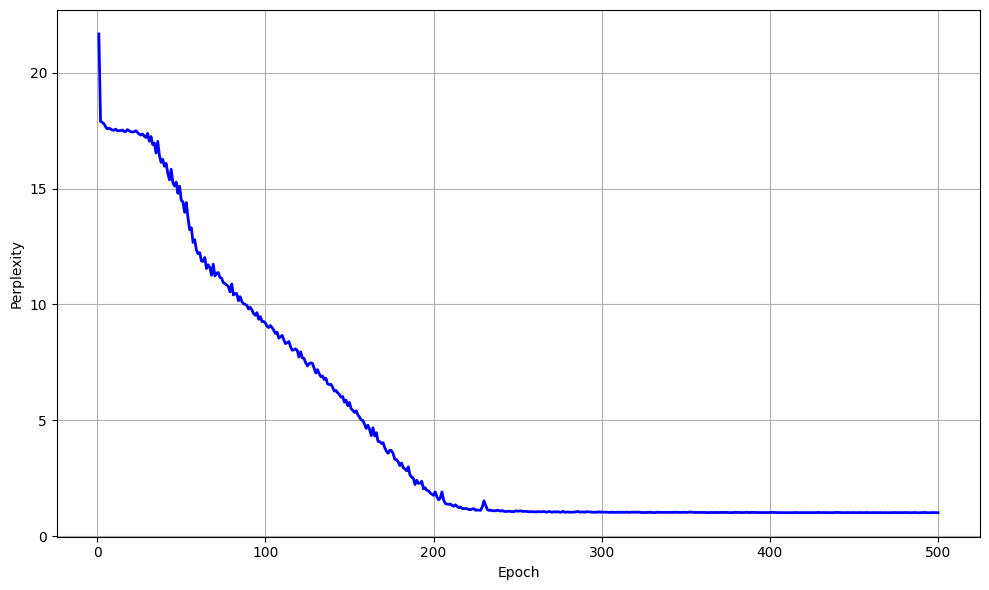

In [4]:
num_epochs, lr = 500, 2
train_ch8(model, train_iter, vocab, lr*1.0, num_epochs, device)

# 双隐藏层循环神经网络（RNN）计算过程详解

本文详细解析一个具有两个隐藏层的循环神经网络（RNN）的核心计算公式、数据流和数据维度变化，帮助理解其在时间序列数据处理中的工作机制。

---

## 参数上下文

假设以下参数：
- **`batch_size`**: `32`
- **`num_steps`**: `35` （时间步数）
- **`input_size`**: `28` （输入特征维度）
- **`num_hiddens`**: `256` （每层隐藏状态的特征维度）
- **`num_layers`**: `2` （隐藏层数）

---

## 双隐藏层 RNN 的核心公式与计算过程

在每个时间步 $t$，双隐藏层 RNN 的计算公式如下：

### 1. 第一隐藏层的状态更新
公式：
$$
H_t^{(1)} = \tanh(X_t W_{xh}^{(1)} + H_{t-1}^{(1)} W_{hh}^{(1)} + b_h^{(1)})
$$

#### 计算过程
- **输入变换**: $X_t W_{xh}^{(1)}$
  - 输入 $X_t$ 的形状为 $[32, 28]$，权重矩阵 $W_{xh}^{(1)}$ 的形状为 $[28, 256]$，结果形状为 $[32, 256]$。
- **隐藏状态变换**: $H_{t-1}^{(1)} W_{hh}^{(1)}$
  - 上一时间步的隐藏状态 $H_{t-1}^{(1)}$ 的形状为 $[32, 256]$，权重矩阵 $W_{hh}^{(1)}$ 的形状为 $[256, 256]$，结果形状为 $[32, 256]$。
- **偏置添加**: $b_h^{(1)}$
  - 偏置向量 $b_h^{(1)}$ 的形状为 $[256]$，通过广播与上述结果相加。
- **激活函数**: $\tanh$
  - 将结果通过 $\tanh$ 激活函数，输出隐藏状态 $H_t^{(1)}$。

#### **最终 $H_t^{(1)}$ 的形状**: $[32, 256]$

---

### 2. 第二隐藏层的状态更新
公式：
$$
H_t^{(2)} = \tanh(H_t^{(1)} W_{xh}^{(2)} + H_{t-1}^{(2)} W_{hh}^{(2)} + b_h^{(2)})
$$

#### 计算过程
- **输入变换**: $H_t^{(1)} W_{xh}^{(2)}$
  - 第一隐藏层的输出 $H_t^{(1)}$ 的形状为 $[32, 256]$，权重矩阵 $W_{xh}^{(2)}$ 的形状为 $[256, 256]$，结果形状为 $[32, 256]$。
- **隐藏状态变换**: $H_{t-1}^{(2)} W_{hh}^{(2)}$
  - 第二隐藏层上一时间步的隐藏状态 $H_{t-1}^{(2)}$ 的形状为 $[32, 256]$，权重矩阵 $W_{hh}^{(2)}$ 的形状为 $[256, 256]$，结果形状为 $[32, 256]$。
- **偏置添加**: $b_h^{(2)}$
  - 偏置向量 $b_h^{(2)}$ 的形状为 $[256]$，通过广播与上述结果相加。
- **激活函数**: $\tanh$
  - 将结果通过 $\tanh$ 激活函数，输出隐藏状态 $H_t^{(2)}$。

#### **最终 $H_t^{(2)}$ 的形状**: $[32, 256]$

---

### 3. 输出计算
公式：
$$
Y_t = H_t^{(2)} W_{hq} + b_q
$$

#### 计算过程
- **隐藏状态变换**: $H_t^{(2)} W_{hq}$
  - 第二隐藏层的输出 $H_t^{(2)}$ 的形状为 $[32, 256]$，权重矩阵 $W_{hq}$ 的形状为 $[256, 28]$，结果形状为 $[32, 28]$。
- **偏置添加**: $b_q$
  - 偏置向量 $b_q$ 的形状为 $[28]$，通过广播与上述结果相加。
- **最终输出 $Y_t$ 的形状**: $[32, 28]$

---

## 数据流与变量维度变化

以下是每个变量在时间步 $t$ 的维度变化过程：

| **变量名称**        | **公式**                                     | **形状**            | **描述**                                   |
|---------------------|----------------------------------------------|---------------------|-------------------------------------------|
| 输入 $X_t$          | -                                            | $[32, 28]$         | 每个时间步的输入特征                       |
| 第一层隐藏状态 $H_t^{(1)}$ | $\tanh(X_t W_{xh}^{(1)} + H_{t-1}^{(1)} W_{hh}^{(1)} + b_h^{(1)})$ | $[32, 256]$ | 第一隐藏层的输出                         |
| 第二层隐藏状态 $H_t^{(2)}$ | $\tanh(H_t^{(1)} W_{xh}^{(2)} + H_{t-1}^{(2)} W_{hh}^{(2)} + b_h^{(2)})$ | $[32, 256]$ | 第二隐藏层的输出                         |
| 输出 $Y_t$          | $H_t^{(2)} W_{hq} + b_q$                    | $[32, 28]$         | 模型的最终输出                            |

---

## 总结

双隐藏层 RNN 的结构通过层数的堆叠，能够学习更加复杂的时间序列特征。每一层的隐藏状态根据前一时间步的信息和当前层的输入进行更新，层与层之间通过隐藏状态传递信息。最终，第二隐藏层的输出通过线性变换生成模型的预测结果。
